In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import funk_svd
from sklearn.decomposition import PCA
from scipy import spatial
from tqdm.auto import tqdm

In [4]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/svd_data/model_100_epochs_regularized.pkl')

## ABX

In [5]:
abx_tests = pd.read_json('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', lines=True)

In [6]:
def get_item_embedding(model, asin):
    item_id = model.item_mapping_[asin]
    return model.qi_[item_id]

In [7]:
A = np.zeros((10000, 100))
B = np.zeros((10000, 100))
X = np.zeros((10000, 100))

In [8]:
for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, test["A"])
    B[i, :] = get_item_embedding(model, test["B"])
    X[i, :] = get_item_embedding(model, test["X"])

0it [00:00, ?it/s]

In [9]:
dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

In [10]:
(dist_A < dist_B).mean()

0.4993

In [11]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)
for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
(cos_dist_A < cos_dist_B).mean()

0.497

## Embeddings PCA

In [13]:
item_embeddings = pd.DataFrame(model.qi_)
user_embeddings = pd.DataFrame(model.pu_)

In [14]:
item_embeddings 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.027093,0.200493,0.012327,-0.064424,0.060932,-0.135025,0.007142,0.028618,0.219861,0.028167,...,-0.037509,0.105246,0.105784,-0.058799,-0.047982,0.060580,-0.117579,0.045617,-0.051980,-0.182251
1,-0.129910,0.076718,-0.075722,-0.088947,0.015685,0.212318,-0.020715,0.048595,0.106749,0.120681,...,0.084251,0.227012,-0.136157,-0.056084,0.112162,0.130839,0.002355,-0.025998,0.122161,0.013401
2,-0.069590,-0.060752,0.084327,-0.072355,-0.087982,-0.026122,-0.044734,0.103885,0.054523,-0.025870,...,0.022427,0.001595,-0.012291,0.185022,-0.086995,-0.026027,0.068204,0.008413,-0.038034,0.025323
3,-0.027520,0.059973,-0.005030,-0.049668,-0.106659,0.235307,0.038208,0.097858,0.003694,-0.174426,...,-0.097035,0.028427,0.254264,-0.003902,0.085354,0.032172,-0.195998,0.017617,-0.033776,-0.142530
4,-0.033219,-0.083011,-0.012319,-0.006387,-0.018950,0.059205,-0.036114,-0.014244,-0.054128,-0.116874,...,-0.045097,0.030470,-0.102508,0.091211,0.133033,-0.084698,0.094136,-0.055443,0.024342,0.038790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206491,0.122710,0.116756,0.094624,0.148047,0.175702,0.236611,0.071418,0.081048,0.046217,0.053043,...,-0.096629,0.006000,0.162323,0.088990,-0.085318,-0.010093,0.064736,0.158960,-0.065320,-0.009291
206492,0.085767,-0.107053,0.114675,0.011189,0.032928,-0.185282,-0.158483,-0.100643,-0.129390,0.098736,...,-0.042587,0.115724,-0.089728,0.152364,-0.078563,0.115891,0.078746,-0.063759,-0.072812,-0.090412
206493,-0.195297,0.046039,-0.027539,-0.119295,-0.085465,0.074906,0.014163,0.077697,-0.022454,-0.204714,...,-0.080014,-0.016928,-0.136869,0.009719,-0.058359,-0.099280,0.055494,-0.088230,0.071114,0.026190
206494,0.061439,0.021428,0.010163,-0.076510,0.082746,-0.212040,-0.049025,0.083171,-0.065163,0.029942,...,-0.053431,0.009302,-0.001648,-0.085932,-0.153319,-0.068296,-0.036478,0.001039,0.048792,0.179969


In [15]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [16]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [17]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

In [18]:
reduced_item_embeddings

,0,1
0,-0.010514,0.125150
1,0.009587,-0.026263
2,0.116748,-0.011677
3,0.059788,0.076536
4,-0.113021,0.106993
...,...,...
206491,0.024109,-0.021756
206492,-0.083212,0.056549
206493,-0.072755,-0.061758
206494,-0.096216,-0.077579


In [19]:
reduced_user_embeddings

,0,1
0,0.108667,-0.053206
1,0.016579,-0.161134
2,0.094403,-0.080154
3,-0.090532,-0.050115
4,0.026174,-0.083541
...,...,...
101039,0.136873,-0.161943
101040,-0.030156,0.053994
101041,0.035218,-0.034665
101042,-0.074710,0.087006


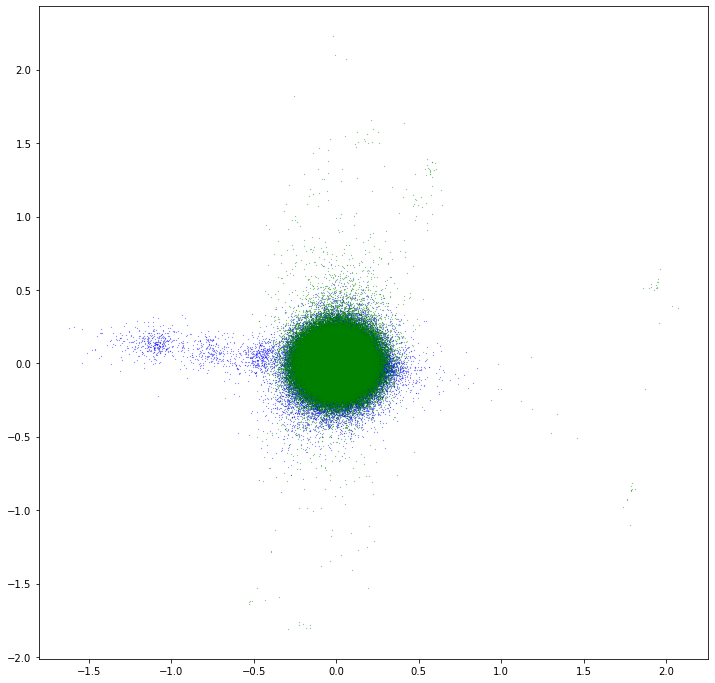

In [20]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)

In [21]:
item_mapping = {v: k for k, v in model.item_mapping_.items()}
user_mapping = {v: k for k, v in model.user_mapping_.items()}

In [22]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [23]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [24]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [25]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

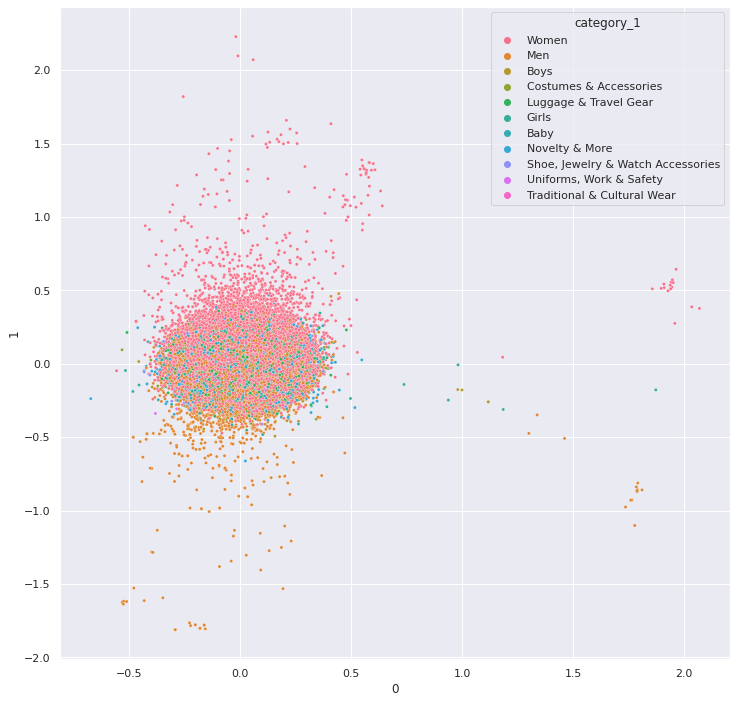

In [26]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

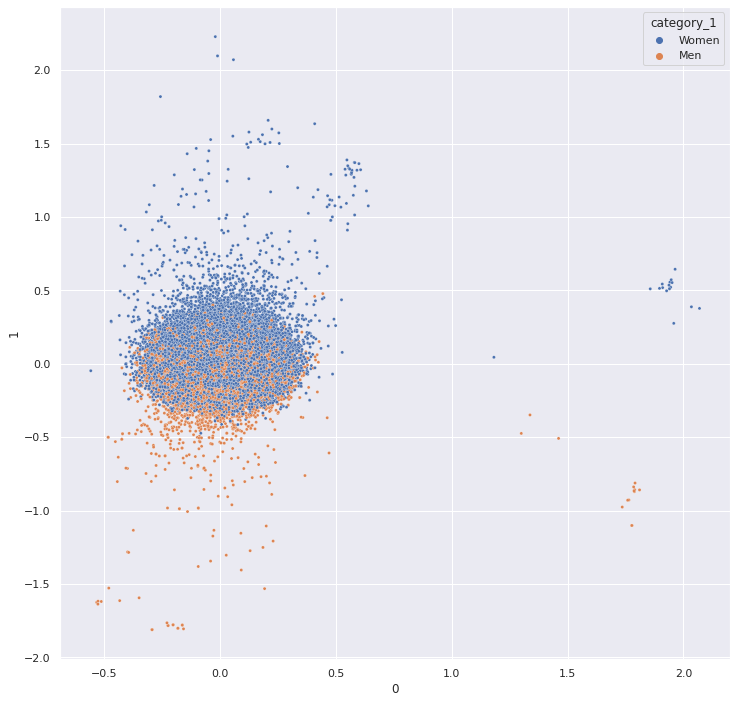

In [27]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)